In [1]:
#!pip install --upgrade ~/Development/repos/tradeframework
#!pip install --upgrade ~/Development/repos/tradeframework-insights
#!pip install --upgrade ~/Development/repos/quantutils
#!pip install --upgrade ~/Development/repos/marketinsights-price-aggregator

import warnings
warnings.filterwarnings(action='ignore')

# Pkg imports
# TODO - dynamic import of SandboxEnv
from tradeframework.environments import SandboxEnvironment  
from marketinsights.api.aggregator import MarketDataAggregator
from marketinsights.remote.ml import MIAssembly
from marketinsights.remote.models import MIModelServer
import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils

# Dev imports
import pandas as pd
import numpy as np

#import matplotlib
#%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)




2023-04-04 16:41:07.840292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:41:07.996474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 16:41:07.996498: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-04 16:41:09.132709: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
modelsvr = MIModelServer(secret="marketinsights-k8s-cred")
assembly = MIAssembly(modelsvr, secret="marketinsights-k8s-cred")

In [7]:
data_config = [
    {
        "ID": "MDS",
        "class": "MDSConnector",
        "opts": {
            "location": "http://localhost:8080"
        },
        "timezone": "UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                    {
                        "ID": "WallSt-hourly",
                        "sample_unit": "H"
                    },
                    {
                        "ID": "D&J-IND",
                        "sample_unit": "5min"
                    }
                ]
            },
            {
                "ID": "SPY",
                "sources": [
                    {
                        "ID":"SP500-hourly",
                        "sample_unit":"H"
                    },
                    {
                        "ID":"SANDP-500",
                        "sample_unit":"5min"
                    }
                ]
            }
        ]
    }
]


## Get Market Data
aggregator = MarketDataAggregator(data_config)
   
start = "2013-01-01" # Train period
end = "2018-08-01"

#start="2018-08-02" # Test period
#end="2018-12-31"

#start="2018-08-02" # Test period
#end="2025-12-31"

marketData = aggregator.getData(mkts=["DOW"], sample_unit="D", start=start, end=end, aggregate=True, debug=False)
print("Data Loaded")
#marketData = marketData.xs("mID")
#marketData = marketData.tz_convert("US/Eastern", level="Date_Time")
#marketData = marketData.unstack(level=0).dropna(axis=1).stack() # Remove rows that don't have values from all markets
#tickers = marketData.index.get_level_values("mID").unique().values


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

Data Loaded


In [8]:
env = SandboxEnvironment("TradeFair", "US/Eastern")
env.createAssets(marketData)

p = env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("EqualWeightsOptimizer"))
env.setPortfolio(p)

# Create baseline as an unweighted asset
baseline = env.createDerivative("Baseline Signal", weightGenerator=env.createModel("BuyAndHold", opts={"barOnly": True}))
baseline.addStoredAsset(["DOW"])
p.addAsset(baseline, weighted=False)

# BuyAndHold
""" p.addAsset(
    env.createDerivative(
        "BuyAndHold", 
        weightGenerator=env.createModel(
            "BuyAndHold", 
            #opts={"start":"19:00", "end":"20:00", "barOnly": True}
            opts={"barOnly": False}
        )).addStoredAsset(["DOW"])) """

# ARIMA
p.addAsset(
    env.createDerivative(
        "ARIMA", 
        weightGenerator=env.createModel(
            "ARIMA", 
            modelModule="tradeframework.models.remote",
            opts={"AR":4, "I":1, "MA":2, "window":5*4*3, "fit":"fitOnce", "params":params, "barOnly": True}
        )).addStoredAsset(["DOW"]))

# Feed data into the portfolio
env.refresh()


In [6]:
params = p.assets[1].weightGenerator.result.params
str(params.tolist())

'[-0.30081263760633137, 0.39470190597557736, -0.04743263387904501, -0.14170836016613247, 0.38866070473072584, -0.3981799528688712, 44444.46650679612]'

In [9]:
p.assets[1].weightGenerator.result.params

array([-3.00812638e-01,  3.94701906e-01, -4.74326339e-02, -1.41708360e-01,
        3.88660705e-01, -3.98179953e-01,  4.44444665e+04])


Augmented Dicker-Fuller Test for Stationarity

H0 = Non-Stationary data
H1 = Stationary data

Critical value: -41.67341124929411
Probability of Non-Stationarity: 0.0%
Number of lags used: 0
Number of observations: 1735
T-Scores:
         -> 10% : -2.5676576190318
         -> 5%  : -2.863207293168388
         -> 1%  : -3.4341246405277706

H0 can be rejected with 100.0% confidence
Conclusion: Data is stationary

Ljung-Box Test for AutoCorrelations

H0 = No Serial AutoCorrelation in the data
H1 = AutoCorrelation exists

Critical value: 27.09839121478962
Probability of White Noise: 13.251845937994808

H0 can be rejected with [0.86748154]% confidence
Conclusion: Data is white noise

Jaque-Bera Test for Normal Distribution

H0 = Data is Normally distributed
H1 = Data may not be Normally distributed

Critical value: 1687.3402293922957
Probability of Normal Distribution: 0.0

H0 can be rejected with 1.0% confidence
Conclusion: Data may not be Normally distributed


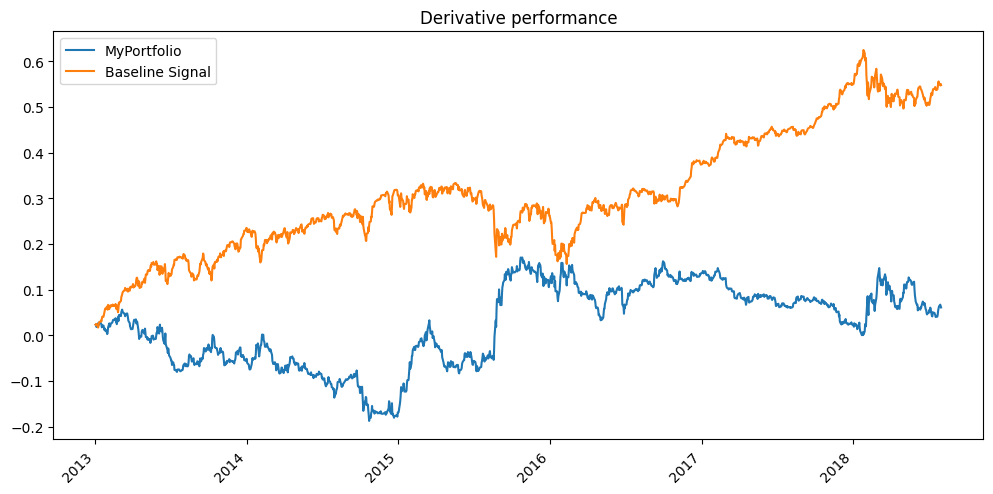

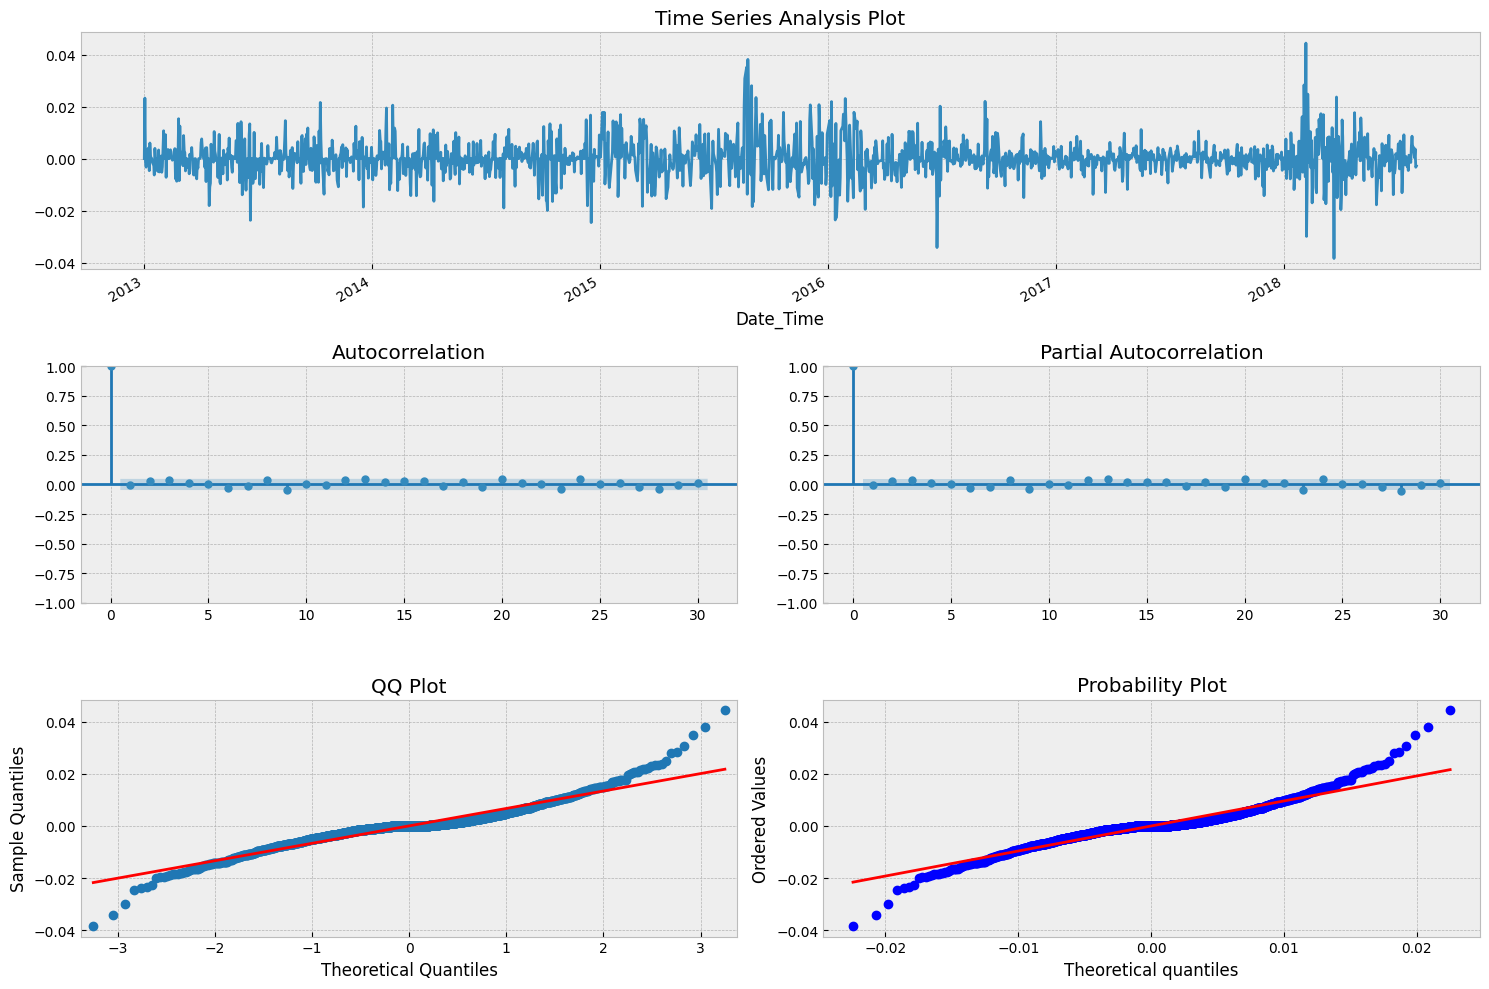

In [10]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

im = InsightManager(p)
im.addInsightGenerator(im.createInsightGenerator("BasicPlot", opts={"baseline":p.assets[0]}))
im.addInsightGenerator(im.createInsightGenerator("AnalysisPlot", opts={"series":"returns"}))
im.addInsightGenerator(im.createInsightGenerator("StationarityTest", opts={"series":"returns"}))
im.addInsightGenerator(im.createInsightGenerator("WhiteNoiseTest", opts={"series":"returns"}))
im.addInsightGenerator(im.createInsightGenerator("NormalityTest", opts={"series":"returns"}))
  
results = im.generateInsights()


In [16]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

im = InsightManager(p)
im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series":np.log(p.assets[0].values["Close"]).diff()[1:]}))

results = im.generateInsights()

im = InsightManager(p)
#im.addInsightGenerator(im.createInsightGenerator("AnalysisPlot", opts={"series":results["ARIMAFit"].resid}))
im.addInsightGenerator(im.createInsightGenerator("StationarityTest", opts={"series":results["ARIMAFit"].resid}))
#im.addInsightGenerator(im.createInsightGenerator("MACFPlot", opts={"series":results["ARIMAFit"].resid})
im.addInsightGenerator(im.createInsightGenerator("WhiteNoiseTest", opts={"series":results["ARIMAFit"].resid}))
im.addInsightGenerator(im.createInsightGenerator("NormalityTest", opts={"series":results["ARIMAFit"].resid}))
  
results = im.generateInsights()

ARIMA:0,0,0, AIC:-7440.662816029129, MFE:4.996844481743962e-06, MAE:0.07712385651957761
ARIMA:0,1,0, AIC:-6500.664252481962, MFE:-8.20111071763238e-06, MAE:inf
ARIMA:0,0,1, AIC:-7453.631037844412, MFE:3.626782691207489e-06, MAE:0.005390750407778205
ARIMA:0,1,1, AIC:-7425.871959720772, MFE:5.1753631446932554e-05, MAE:inf
ARIMA:0,0,2, AIC:-7453.751354994642, MFE:3.3230224873354193e-06, MAE:0.005267007946091965
ARIMA:0,1,2, AIC:-7438.6004848697285, MFE:5.9224153730657735e-05, MAE:inf
ARIMA:0,0,3, AIC:-7464.2643266921605, MFE:4.313352307249537e-06, MAE:-0.00773894082947563
ARIMA:0,1,3, AIC:-7438.882585730082, MFE:5.405274825965503e-05, MAE:inf
ARIMA:0,0,4, AIC:-7469.948090841857, MFE:6.1196447512573846e-06, MAE:-0.004489576252736426
ARIMA:0,1,4, AIC:-7435.4600820941, MFE:3.680155694197121e-06, MAE:inf
ARIMA:1,0,0, AIC:-7454.963863225506, MFE:2.4534577092933636e-06, MAE:0.007998339850644106
ARIMA:1,1,0, AIC:-6974.389889467233, MFE:-2.5619524403703867e-07, MAE:inf
ARIMA:1,0,1, AIC:-7451.2477

In [17]:
mlutils.evaluate(ppl.onehot(predictions[["y_pred0"]].values), ppl.onehot(predictions[[9]].values), threshold=0.5)

Won : 576.0
Lost : 579.0
Total : 1155.0
Diff : -3.0
Edge : -0.2597402597402597%
IR : -0.08827348


0.4987013

In [18]:
mlutils.evaluate(ppl.onehot(np.ones(predictions[[9]].values.shape)), ppl.onehot(predictions[[9]].values), threshold=0.5)

Won : 562.0
Lost : 593.0
Total : 1155.0
Diff : -31.0
Edge : -2.683982683982684%
IR : -0.91215926


0.48658007

In [4]:
import pandas as pd
import numpy as np
from tradeframework.api.core import Model
import statsmodels.api as sm
from typing import Literal
from tqdm import tqdm


class ARIMA(Model):
    """Creates a predictive model based on an ARIMA timeseries model"""

    def __init__(self, env, AR=0, I=0, MA=0, window=1000, fit: Literal["fitAll", "fitWindow", "fitOnce", "inSample"] = "inSample", barOnly=True):
        Model.__init__(self, env, window)
        self.AR = AR
        self.I = I
        self.MA = MA
        self.fit = fit
        self.barOnly = barOnly

    def getSignals(self, window, idx=0):

        signals = pd.DataFrame(
            np.zeros((len(window), 2)),
            index=window.index,
            columns=["bar", "gap"],
        )

        if self.fit == "inSample":
            
            # For development and analysis purposes, get "predictions" of in-sample values
            self.result = sm.tsa.arima.ARIMA(window["Close"].values, order=(self.AR, self.I, self.MA)).fit()
            predictions = self.result.predict(start=0, end=len(window)-1)
                
            predictionSignals = np.sign(
                predictions - window["Close"].shift().values
            )

            predictionSignals = pd.DataFrame(
                np.array([predictionSignals, predictionSignals]).T,
                index=window.index,
                columns=["bar", "gap"],
            )
            
        elif len(window) > self.window:

            dataLen = len(window) - self.window
            res = sm.tsa.arima.ARIMA(
                window[: self.window]["Close"].values, order=(self.AR, self.I, self.MA)
            ).fit()
            
            if self.fit == "fitOnce":            

                # Fit to an initial window, then predict all based on fitted model.
                res = res.append(window[self.window:]["Close"].values)    
                predictions = res.predict(start=self.window, end=len(window)-1)
                    
            else:
                predictions = np.array([res.forecast()[0]])

                for i in tqdm(range(1, dataLen)):
                    if self.fit == "fitAll":
                        # Fit to an ever increasing window and predict next step

                        predictions = np.array([res.forecast()[0]])
                        res = res.append(
                            window[self.window + i - 1 : self.window + i]["Close"].values,
                            refit=True
                        )
                    elif self.fit == "fitWindow":
                        # Fit to an rolling window and predict next step
                        res = sm.tsa.arima.ARIMA(
                            window[i:i+self.window]["Close"].values, order=(self.AR, self.I, self.MA)
                        ).fit()
                        
                    predictions = np.append(predictions, res.forecast()[0])

            predictionSignals = np.sign(
                predictions - window[self.window - 1 : -1]["Close"].values
            )

            predictionSignals = pd.DataFrame(
                np.array([predictionSignals, predictionSignals]).T,
                index=window[self.window :].index,
                columns=["bar", "gap"],
            )

        if self.barOnly:
            predictionSignals["gap"] = 0

        signals.update(predictionSignals)

        return signals[idx:]


In [33]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 9498#24*5*4*3
x = x.iloc[-window-100:]
r = len(x) - window
predictions = np.array([sm.tsa.arima.ARIMA(x[i:i+window]["Close"].values, order=(3, 1, 5)).fit().forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

array([ 1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.])

In [238]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-1000:]
r = len(x) - window
params = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit().params
predictions = np.array([sm.tsa.arima.ARIMA(x[i:i+window]["Close"].values, order=(3, 1, 5)).filter(params).forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([-1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
       -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1

In [280]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
predictions = np.array([res.apply(x[i:i+window]["Close"].values, refit=True).forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

array([ 1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.])

In [290]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-100:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = np.array([res.forecast()[0]])
for i in range(1, r):
    res = res.append(x[window+i-1:window+i]["Close"].values, refit=True)
    #print(x[window+i-1:window+i]["Close"].values)
    predictions = np.append(predictions, res.forecast()[0])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([-1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
       -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.])

In [62]:
import statsmodels.api as sm
x = marketData.xs("DOW")
#window = 24*5*4*3
#x = x.iloc[-10:]
#r = len(x) - window
res = sm.tsa.arima.ARIMA(x["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = res.predict(start=len(x)-10, end=len(x)-1)
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

ValueError: operands could not be broadcast together with shapes (10,) (8068,) 

In [190]:
import statsmodels.api as sm
y = marketData.xs("DOW")
window = 24*5*4*3
x = y.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = np.array([res.forecast()[0]])
for i in range(1, r):
    res = res.extend(x[window+i-1:window+i]["Close"].values)
    #print(x[window+i-1:window+i]["Close"].values)
    predictions = np.append(predictions, res.forecast()[0])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.])

In [198]:
import statsmodels.api as sm
y = marketData.xs("DOW")
window = 24*5*4*3
x = y.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
#predictions2 = np.array([res.forecast()[0]])

res = res.append(x[window:]["Close"].values)
    #print(x[window+i-1:window+i]["Close"].values)
predictions2 = res.predict(start=len(x)-10, end=len(x)-1)
signals2 = np.sign(predictions2 - x[window-1:-1]["Close"].values)
signals2

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.])

In [199]:
predictions2

array([25362.6742862 , 25356.89759519, 25370.59228602, 25362.35768089,
       25360.84946418, 25330.26384022, 25335.66772374, 25334.57961911,
       25335.74281298, 25334.357043  ])

In [191]:
predictions

array([25362.6742862 , 25356.89759519, 25370.59228602, 25362.35768089,
       25360.84946418, 25330.26384022, 25335.66772374, 25334.57961911,
       25335.74281298, 25334.357043  ])

In [64]:
x[-10:]["Close"]

Date_Time
2023-03-16 20:00:00+00:00    32247.638805
2023-03-16 21:00:00+00:00    32247.588803
2023-03-17 13:00:00+00:00    32012.540867
2023-03-17 14:00:00+00:00    31855.235556
2023-03-17 15:00:00+00:00    31809.454010
2023-03-17 16:00:00+00:00    31899.177039
2023-03-17 17:00:00+00:00    31912.627494
2023-03-17 18:00:00+00:00    31811.364074
2023-03-17 19:00:00+00:00    31859.435698
2023-03-17 20:00:00+00:00    31863.055820
Name: Close, dtype: float64

In [199]:
mod = sm.tsa.statespace.SARIMAX(x[:window]["Close"].values, order=(3, 1, 5))
#res = mod.fit(disp=False)

In [161]:
res.apply(x[window-10:window]["Close"].values).forecast()


array([32246.08159955])

In [201]:
res.forecast()

array([32245.7395778])

In [18]:
y = marketData.xs("DOW")
len(y)

9508

In [289]:
sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).filter(params).forecast()

array([32228.23928744])

In [224]:
import tradeframework.operations.utils as utils
np.log(utils.getPeriodReturns(p.returns) + 1)[-5:].values[0][0]


-2.448366808491554e-05

In [231]:
p.assets[1].returns

,Open,Close
Date_Time,,
2013-01-01 05:00:00+00:00,0.0,0.000000
2013-01-01 22:15:00+00:00,0.0,0.000000
2013-01-02 05:00:00+00:00,0.0,0.000000
2013-01-02 14:30:00+00:00,0.0,0.000000
2013-01-02 14:35:00+00:00,0.0,0.000000
...,...,...
2023-03-17 20:00:00+00:00,0.0,-0.000069
2023-03-17 20:05:00+00:00,0.0,0.000000
2023-03-17 20:10:00+00:00,0.0,0.000000
